In [519]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [520]:
%matplotlib notebook

# Data Processing

In [522]:


# COL_NAMES = ["t", "is_crashed",
#              "roll", "pitch", "yaw", "throttle",
#              "roll_pid_out", "pitch_pid_out", "yaw_pid_out",
#              "motor_fl", "motor_bl", "motor_fr", "motor_br", 
#              "pwm_fl", "pwm_bl", "pwm_fr", "pwm_br"]
# COL_DATATYPES = {0: int, 1: bool,
#              2: float, 3: float, 4: float, 5: float,
#              6: float, 7: float, 8: float,
#              9: float, 10: float, 11: float, 12: float, 
#              13: int, 14: int, 15: int, 16: int}

def load_csv(file):
    # File locations
    log_path = "../logs/" + file

    csv_df = pd.read_csv(log_path)
    csv_df.columns = csv_df.columns.str.replace(" ","")

    return csv_df

In [957]:
# Load flight logs
flight_df = load_csv("flight_120")
flight_df.head(n=500)

,t,is_crashed,roll,pitch,yaw,p,q,r,throttle,p_cmd,...,pitch_pid_out,yaw_pid_out,motor_fl,motor_bl,motor_fr,motor_br,pwm_fl,pwm_bl,pwm_fr,pwm_br
0,7002,0,0.625000,0.337500,71.987503,0.00,0.00,0.000207,0.005,0.0,...,-0.000002,-0.000002,0.000000,0.000000,0.000000,0.000000,0,0,0,0
1,7014,0,1.000000,0.540000,129.577499,0.16,0.08,0.000291,0.005,0.0,...,-0.000680,-0.000003,0.000000,0.000000,0.000000,0.000000,819,819,819,819
2,7024,0,1.300000,0.702000,175.649506,0.29,0.16,0.000367,0.005,0.0,...,-0.001265,-0.000004,0.000000,0.000000,0.000000,0.000000,819,819,819,819
3,7034,0,1.540000,0.831600,-147.492889,0.38,0.21,0.000436,0.005,0.0,...,-0.001660,-0.000004,0.000000,0.000000,0.000000,0.000000,819,819,819,819
4,7044,0,1.732000,0.935280,-118.006805,0.44,0.24,0.000291,0.005,0.0,...,-0.001913,-0.000003,0.000000,0.000000,0.000000,0.000000,819,819,819,819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,12158,0,3.972735,-2.341467,56.459187,-1.91,-0.41,0.080684,0.311,0.0,...,0.003319,-0.000789,0.321634,0.316573,0.307005,0.298788,1082,1098,1070,1084
496,12168,0,3.903188,-2.515674,57.467350,-1.95,-0.43,0.061309,0.311,0.0,...,0.003535,-0.000595,0.322178,0.316299,0.306891,0.298631,1083,1098,1070,1084
497,12178,0,3.847550,-2.692539,58.498882,-1.97,-0.46,0.047402,0.311,0.0,...,0.003737,-0.000456,0.322631,0.316070,0.306843,0.298456,1083,1098,1070,1084
498,12194,0,3.803040,-2.884032,59.549107,-1.98,-0.45,0.029634,0.311,0.0,...,0.003667,-0.000279,0.322794,0.316018,0.306539,0.298649,1083,1098,1070,1084


In [958]:
# Time - DF -> Numpy
t_df = flight_df['t']
t_np = t_df.to_numpy(dtype=np.int32)
t_np = t_np / 1000

# Crashed flag
crash_df = flight_df[['is_crashed']]
crash_np = crash_df.to_numpy()

# Roll / Pitch / Yaw - DF -> Numpy
rpy_df = flight_df[['roll', 'pitch', 'yaw']]
rpy_np = rpy_df.to_numpy()

# Roll / Pitch / Yaw Commands - DF -> Numpy
rpy_cmd_df = flight_df[['roll_cmd', 'pitch_cmd', 'yaw_cmd']]
rpy_cmd_np = rpy_cmd_df.to_numpy()

# Roll / Pitch / Yaw Rates - DF -> Numpy
pqr_df = flight_df[['p', 'q', 'r']]
pqr_np = pqr_df.to_numpy()

# PID Outputs - DF -> Numpy
pid_df = flight_df[['roll_pid_out', 'pitch_pid_out', 'yaw_pid_out', 'p_cmd', 'q_cmd', 'r_cmd']]
pid_np = pid_df.to_numpy()

# Motor % - DF -> Numpy
power_df = flight_df[['motor_fl', 'motor_bl', 'motor_fr', 'motor_br']]
power_np = power_df.to_numpy()

# Throttle - DF -> Numpy
throttle_df = flight_df['throttle']
throttle_np = throttle_df.to_numpy()

In [959]:
# Plotting indices
idx_start = 0
idx_end = np.size(t_np)

# Clip variables
t_clip = t_np[idx_start:idx_end]

In [960]:
""" 
Data clipping
"""

is_crash = crash_np[idx_start:idx_end]

roll = rpy_np[idx_start:idx_end, 0]
pitch = rpy_np[idx_start:idx_end, 1]
yaw = rpy_np[idx_start:idx_end, 2]

roll_cmd = rpy_cmd_np[idx_start:idx_end, 0]
pitch_cmd = rpy_cmd_np[idx_start:idx_end, 1]
yaw_cmd = rpy_cmd_np[idx_start:idx_end, 2]

p = pqr_np[idx_start:idx_end, 0]
q = pqr_np[idx_start:idx_end, 1]
r = pqr_np[idx_start:idx_end, 2]

p_pid = pid_np[idx_start:idx_end, 0]
q_pid = pid_np[idx_start:idx_end, 1]
r_pid = pid_np[idx_start:idx_end, 2]
roll_pid = pid_np[idx_start:idx_end, 3]
pitch_pid = pid_np[idx_start:idx_end, 4]
yaw_pid = pid_np[idx_start:idx_end, 5]

# Note: p,q,r cmds are the outer loop PID outputs.
p_cmd = roll_pid
q_cmd = pitch_pid
r_cmd = yaw_pid

# Crash Detection

<IPython.core.display.Javascript object>


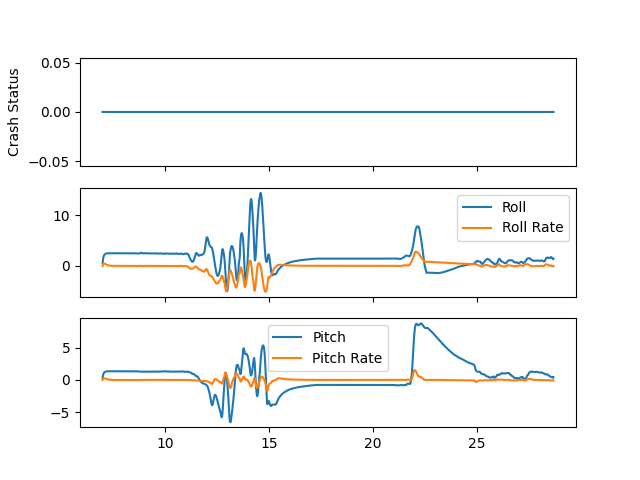

In [961]:
f, axs = plt.subplots(3, sharex=True)

axs[0].plot(t_clip, is_crash, label="Crashed?")
axs[0].set_ylabel("Crash Status")

axs[1].plot(t_clip, roll, label="Roll")
axs[1].plot(t_clip, p, label="Roll Rate")
axs[1].legend()

axs[2].plot(t_clip, pitch, label="Pitch")
axs[2].plot(t_clip, q, label="Pitch Rate")
axs[2].legend()

plt.show()

# Plotting Utilities

In [962]:
def plot_rate(cmd, x, x_rate, pid=None, label=None):
    if pid is None:
        f, axs = plt.subplots(2, sharex=True)
    else:
        f, axs = plt.subplots(3, sharex=True)
    
    state_name = "angle"
    if label is not None:
        state_name = label

    axs[0].plot(t_clip, x, label=f"{state_name}")
    axs[0].plot(t_clip, cmd, label=f"{state_name} cmd")
    axs[0].legend()
    axs[0].set_ylabel(f"{state_name} (deg/s)")

    axs[1].plot(t_clip, x_rate, label=f"{state_name} rate")
    axs[1].set_ylabel(f"{state_name} rate (deg/s^2)")
    
    if pid is not None:
        axs[2].plot(t_clip, pid, label=f"{state_name} PID")
        axs[2].set_ylabel(f"{state_name} PID (%)")

    plt.show()

def plot_angle(cmd, x, x_rate, pid=None, label=None):
    if pid is None:
        f, axs = plt.subplots(2, sharex=True)
    else:
        f, axs = plt.subplots(3, sharex=True)
    
    state_name = "angle"
    if label is not None:
        state_name = label

    axs[0].plot(t_clip, x, label=f"{state_name}")
    axs[0].plot(t_clip, cmd, label=f"{state_name} cmd")
    axs[0].legend()
    axs[0].set_ylabel(f"{state_name} (deg)")

    axs[1].plot(t_clip, x_rate, label=f"{state_name} rate")
    axs[1].set_ylabel(f"{state_name} rate (deg/s)")
    
    if pid is not None:
        axs[2].plot(t_clip, pid, label=f"{state_name} PID")
        axs[2].set_ylabel(f"{state_name} PID (deg/s)")

    plt.show()

# Roll Control

## Inner Loop

<IPython.core.display.Javascript object>


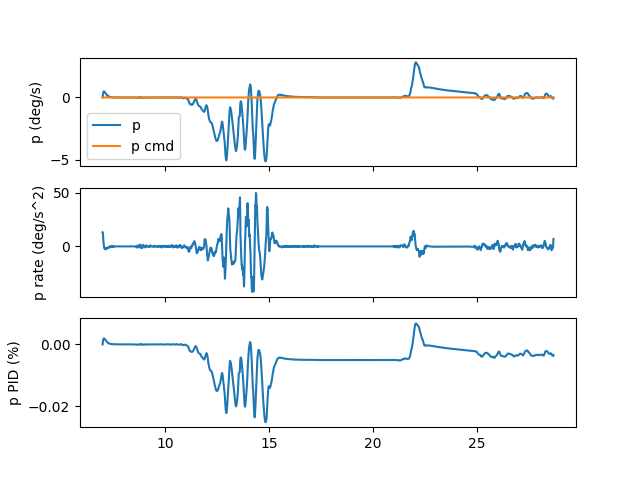

In [963]:
plot_rate(p_cmd, p, np.gradient(p, t_clip), p_pid, "p")

## Outer Loop

<IPython.core.display.Javascript object>


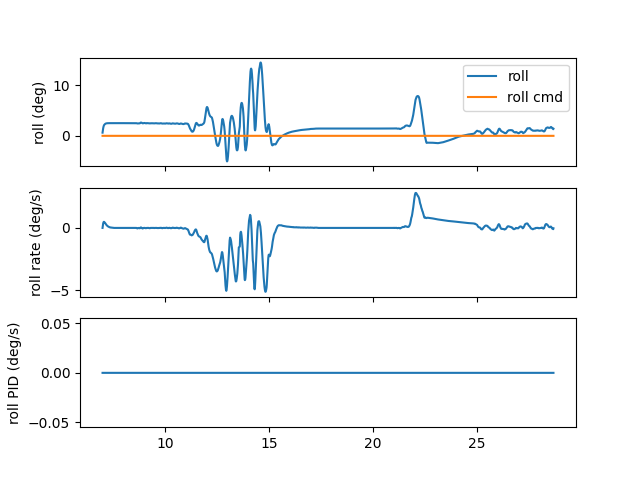

In [964]:
plot_angle(roll_cmd, roll, p, np.degrees(roll_pid), label="roll")

# Pitch Control

## Inner Loop

<IPython.core.display.Javascript object>


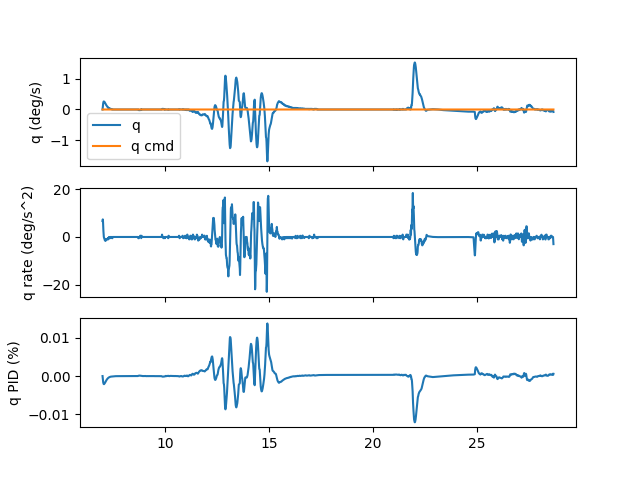

In [965]:
plot_rate(q_cmd, q, np.gradient(q, t_clip), q_pid, "q")

## Outer Loop

<IPython.core.display.Javascript object>


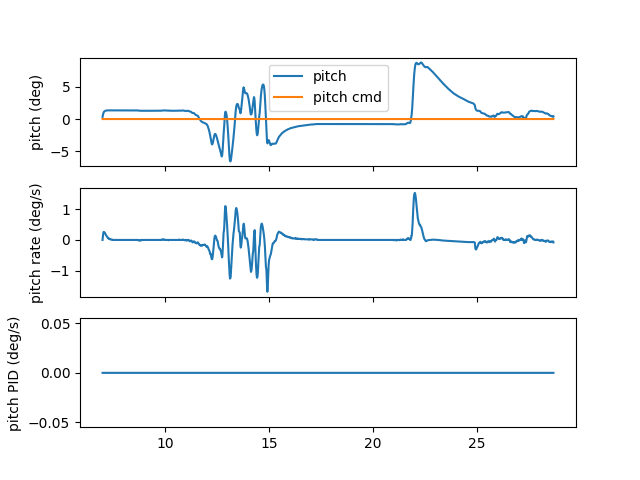

In [966]:
plot_angle(pitch_cmd, pitch, q, np.degrees(pitch_pid), label="pitch")

# Yaw Control

## Inner Loop

<IPython.core.display.Javascript object>


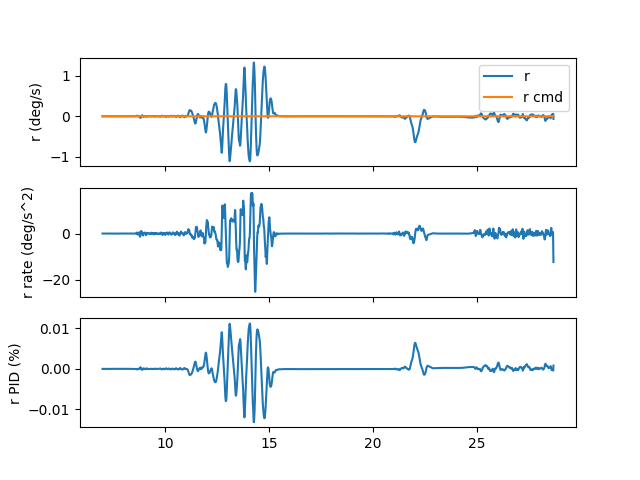

In [967]:
plot_rate(r_cmd, r, np.gradient(r, t_clip), r_pid, "r")

## Outer Loop

<IPython.core.display.Javascript object>


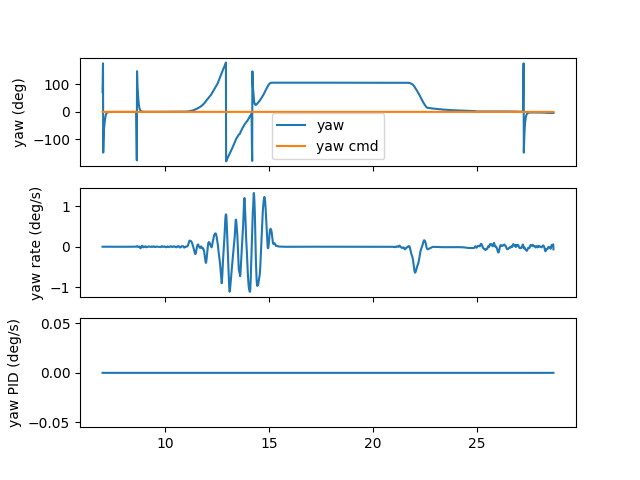

In [968]:
plot_angle(yaw_cmd, yaw, r, yaw_pid, label="yaw")

# Motor Allocation

In [969]:
MAX_PWM = 2**14 - 1

def motor_pwm_to_pct(pwm, min_pwm_duty=0.051*MAX_PWM, max_pwm_duty=0.1*MAX_PWM):
    # Get PWM range in microseconds
    duty_range = max_pwm_duty - min_pwm_duty
    
    # Get the pwm distance from the lower limit
    pwm_offset = pwm - min_pwm_duty
    
    # Find the power
    power = pwm_offset / duty_range
    
    return power

<IPython.core.display.Javascript object>


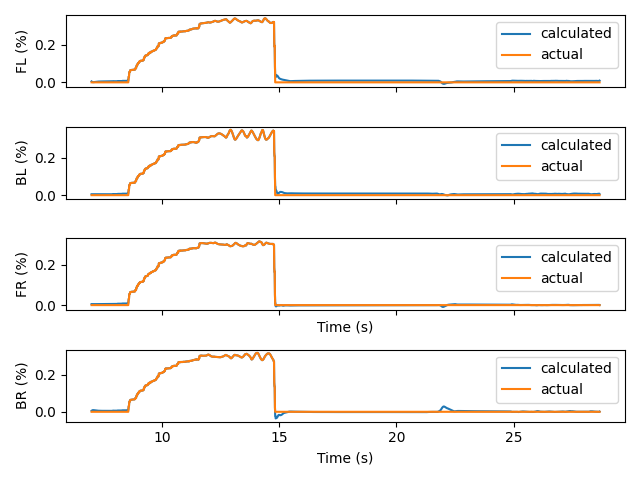

In [970]:
throttle_pct = throttle_np #* 0 + 0.5
front_left_out  = throttle_pct - p_pid + q_pid + r_pid
back_left_out   = throttle_pct - p_pid - q_pid - r_pid
front_right_out = throttle_pct + p_pid + q_pid - r_pid
back_right_out  = throttle_pct + p_pid - q_pid + r_pid

# Get actual motor powers
fl_power = power_np[idx_start:idx_end, 0]
bl_power = power_np[idx_start:idx_end, 1]
fr_power = power_np[idx_start:idx_end, 2]
br_power = power_np[idx_start:idx_end, 3]

# Plotting expected motor thrust allocation
f, axs = plt.subplots(4, sharex=True)

axs[0].plot(t_clip, front_left_out, label='calculated')
axs[0].plot(t_clip, fl_power, label='actual')
axs[0].set_ylabel("FL (%)")
axs[0].legend()

axs[1].plot(t_clip, back_left_out, label='calculated')
axs[1].plot(t_clip, bl_power, label='actual')
axs[1].set_ylabel("BL (%)")
axs[1].legend()

axs[2].plot(t_clip, front_right_out, label='calculated')
axs[2].plot(t_clip, fr_power, label='actual')
axs[2].set_ylabel("FR (%)")
axs[2].set_xlabel("Time (s)")
axs[2].legend()

axs[3].plot(t_clip, back_right_out, label='calculated')
axs[3].plot(t_clip, br_power, label='actual')
axs[3].set_ylabel("BR (%)")
axs[3].set_xlabel("Time (s)")
axs[3].legend()

f.tight_layout()

plt.show()

In [971]:
yaw_pid

array([0., 0., 0., ..., 0., 0., 0.])

<IPython.core.display.Javascript object>


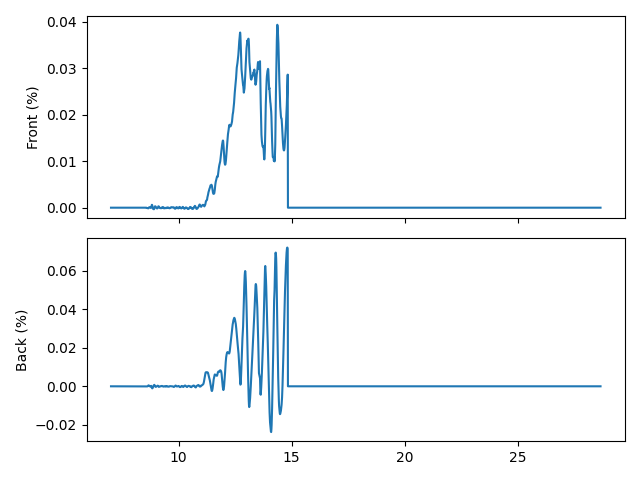

In [972]:
# Left - Right
front_delta = fl_power - fr_power
back_delta  = bl_power - br_power

# Plotting expected motor thrust allocation
f, axs = plt.subplots(2, sharex=True)

axs[0].plot(t_clip, front_delta)
axs[0].set_ylabel("Front (%)")

axs[1].plot(t_clip, back_delta)
axs[1].set_ylabel("Back (%)")

f.tight_layout()

plt.show()